# Neural Style

In this session we will use the approach described in [this paper](https://arxiv.org/abs/1508.06576) to apply a particular style to a content image by means of optimization using the weights of a pretrained convnet (VGG16).

In [1]:
import matplotlib.pyplot as plt  
%matplotlib inline
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input
import numpy as np
from style import * 
from scipy.misc import imread

Using TensorFlow backend.


Let's first display the images we chose. We want to transfer the style of the second image into the first one.

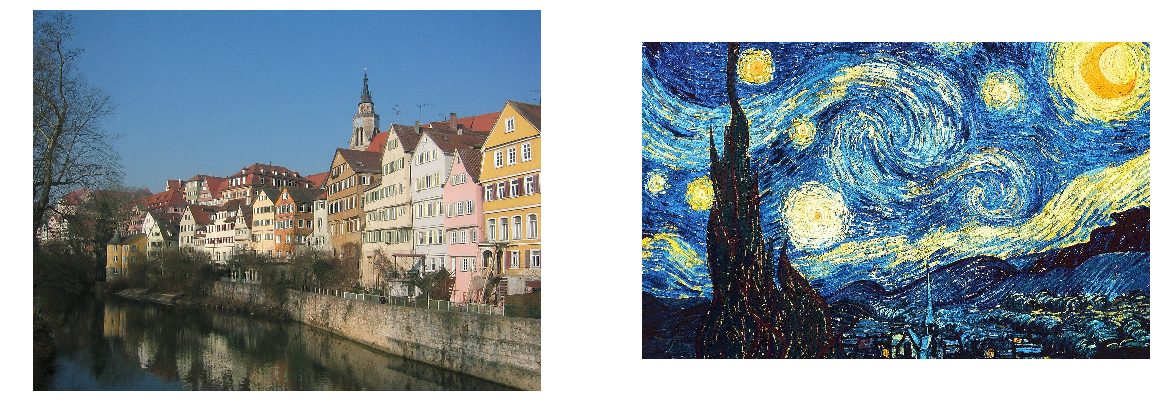

In [2]:
base_image_path = '../images/neural_style/source/tubingen.jpg'
style_reference_image_path = '../images/neural_style/style/starry_night.jpg'

f, axarr = plt.subplots(1,2,figsize=(20,20))
axarr[0].imshow(imread(base_image_path))
axarr[0].axis('off')
axarr[1].imshow(imread(style_reference_image_path))
axarr[1].axis('off')
plt.show()

We load both images and create tensor representations of the appropriate size. We also define the ```input_tensor``` which will be the input that VGG expects.

In [3]:
from keras.preprocessing.image import load_img

width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path,img_nrows,img_ncols))
style_reference_image = K.variable(preprocess_image(style_reference_image_path,img_nrows,img_ncols))

combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# this is the tensor that we will use as input to VGG (the content, style, and the combination images concatenated)
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

Load VGG and get a dictionary of all its layers:

In [4]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)

# get the symbolic outputs of each "key" layer
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Here we choose the layers of the network that we want to use to represent the style and the content. You can play with different combinations if you wish.

In [5]:
# content layers
content_layers = ['block4_conv2']

# style layers
style_layers = ['block1_conv1', 'block2_conv1',
                'block3_conv1', 'block4_conv1',
                'block5_conv1']

Here we define the loss as the combination of the style and content losses:

<img src="figs/style-equation.png">

In [6]:
style_weight = 0.5
content_weight = 0.5

# combine these loss functions into a single scalar
loss = K.variable(0.)

# loss for content layers
for layer_name in content_layers:
    layer_features = outputs_dict[layer_name]

    # we get the content features from the content image and the combination image
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    # content_loss is defined in style.py
    cl = content_loss(base_image_features,combination_features)
    loss += (content_weight / len(content_layers)) * cl

# loss for style layers
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    
    # get style features from style and combination images
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    # style_loss is defined in style.py
    sl = style_loss(style_reference_features, combination_features,img_nrows,img_ncols)
    loss += (style_weight / len(style_layers)) * sl

We will also include a third loss term, which encourages spatial smoothness in the generated image. Although this was not included in the original paper, it often improves results.

In [7]:
total_variation_weight = 1.0
# total_variation_loss is defined in style.py - preserves local coherence
loss += total_variation_weight*total_variation_loss(combination_image,img_nrows,img_ncols)

Next, we get the function that computes the gradient of the combination image with respect to the total loss.

In [8]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

# final function that will give the gradients of the generated image wrt the loss
f_outputs = K.function([combination_image], outputs)

And now we iterate. At each iteration, the combination image ```x``` will be updated based on the gradients.

In [9]:
# the Evaluator class is defined in style.py
evaluator = Evaluator(img_nrows,img_ncols,f_outputs)

ims = []
iterations = 10

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

# we start with random image - this will be updated to be the combination of content and style images
x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.

for i in range(iterations):    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    
    print(i,'Current loss value:', min_val)
    # deprocess_image is defined in style.py
    img = deprocess_image(x.copy(),img_nrows,img_ncols)
    
    # append image to display later
    ims.append(img)

(0, 'Current loss value:', 3.4465788e+10)
(1, 'Current loss value:', 2.430669e+10)
(2, 'Current loss value:', 2.1680191e+10)
(3, 'Current loss value:', 2.0499026e+10)
(4, 'Current loss value:', 1.9802112e+10)
(5, 'Current loss value:', 1.9322927e+10)
(6, 'Current loss value:', 1.8981853e+10)
(7, 'Current loss value:', 1.872947e+10)
(8, 'Current loss value:', 1.8534095e+10)
(9, 'Current loss value:', 1.8380681e+10)


We will plot the images in the last 5 iterations.

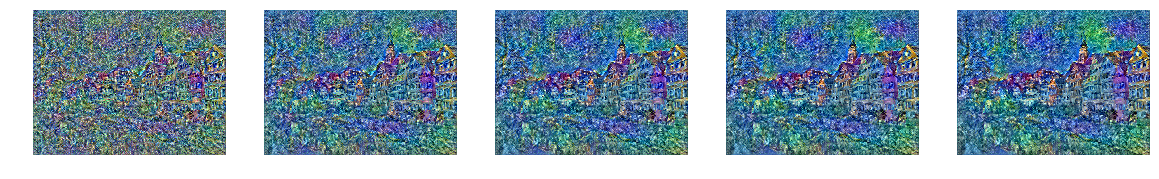

In [10]:
f, axarr = plt.subplots(1, len(ims[:5]),figsize=(20,20))

for i,im in enumerate(ims[:5]):
    axarr[i].imshow(im)
    axarr[i].axis('off')
plt.show()

We display the last image with higher resolution:

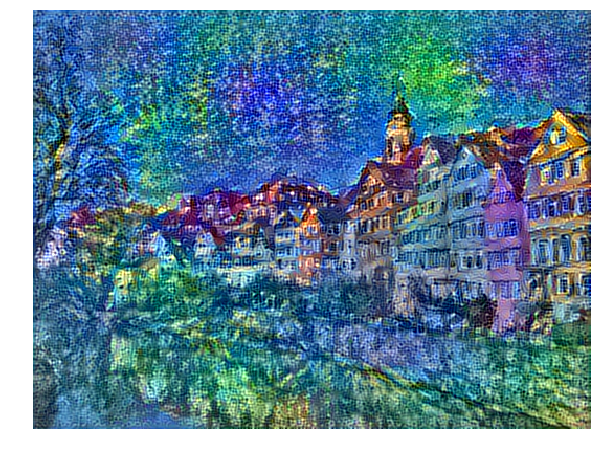

In [11]:
plt.figure(figsize=(10,10)) 
plt.imshow(ims[-1])
plt.axis('off')
plt.show()

**Exercise:** You can find more source and style images in the same folders as the ones we used in the example. Try with other images and see what happens. You can also experiment with different layers in the network, different weights, or different number of iterations.